<a href="https://colab.research.google.com/github/cthoyt/notebooks/blob/master/pykeen_remix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade git+https://github.com/pykeen/pykeen.git

  Cloning https://github.com/pykeen/pykeen.git to /tmp/pip-req-build-dujem6sk
  Running command git clone -q https://github.com/pykeen/pykeen.git /tmp/pip-req-build-dujem6sk
  Created wheel for pykeen: filename=pykeen-1.4.1.dev0-cp37-none-any.whl size=417035 sha256=ec63894986f741533ea4b7c1ed68cc714fa23f4bdb114e4b54635f323ca678dd
  Stored in directory: /tmp/pip-ephem-wheel-cache-41mkknas/wheels/74/a1/d4/48d8d9b30656b3fd0109317017fac61feee101d27c2203c179
Successfully built pykeen
  Found existing installation: pykeen 1.4.1.dev0
    Uninstalling pykeen-1.4.1.dev0:
      Successfully uninstalled pykeen-1.4.1.dev0


In [2]:
import sys
import os
import getpass
import time
import pykeen
import pykeen.utils
import tabulate
import logging

import matplotlib.pyplot as plt
from pykeen.pipeline import pipeline
from IPython.display import HTML
from pykeen.datasets import get_dataset
from tqdm.autonotebook import trange
import seaborn as sns
import pandas as pd

%matplotlib inline

logging.getLogger('pykeen').setLevel(logging.WARNING)
print('Python', sys.version)
print('Time:', time.asctime())
print('User:', getpass.getuser())
print('PyKEEN Version:', pykeen.get_version(with_git_hash=True))

Python 3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0]
Time: Sun Apr 11 19:25:57 2021
User: root
PyKEEN Version: 1.4.1-dev-UNHASHED


In [3]:
device = pykeen.utils.resolve_device('gpu')
device

device(type='cuda')

In [58]:
results = {}

In [67]:
frequency = 2
number_remixes = 5
number_replicates = 5
metric = 'adjusted_mean_rank'
dataset = get_dataset(dataset='kinships')

for i_remix in trange(number_remixes, desc='Remixes'):
    d = dataset.remix(i_remix)
    for i_replicate in trange(number_replicates, desc='Replicates', leave=False):
        if (i_remix, i_replicate) in results:
            continue  # no need to re-calculate
        r = pipeline(
            dataset=d,
            model='PairRE',
            loss='NSSA',
            training_kwargs=dict(
                num_epochs=40, 
                tqdm_kwargs=dict(leave=False),
            ),
            evaluation_kwargs=dict(tqdm_kwargs=dict(leave=False)),
            random_seed=i_replicate,
            device=device,
            stopper='early',
            stopper_kwargs=dict(
                frequency=frequency,
                patience=10,
                # make very small so it never actually stops.
                # This is a hack for now while we don't have 
                # epoch-based evaluaton
                metric=metric,
                relative_delta=0.00001,
            ),
        )
        results[i_remix, i_replicate] = dict(
            losses=r.losses,
            stopper=r.stopper, 
            result=r.metric_results.get_metric(metric), 
        )

In [68]:
loss_df = pd.DataFrame(
    [
        (remix, replicate, epoch, loss)
        for (remix, replicate), data in results.items()
        for epoch, loss in enumerate(data['losses'])
    ],
    columns=['remix', 'replicate', 'epoch', 'loss'],
)
val_df = pd.DataFrame(
    [
        (remix, replicate, frequency * i, val)
        for (remix, replicate), data in results.items()
        for i, val in enumerate(data['stopper'].results)
    ],
    columns=['remix', 'replicate', 'epoch', metric],
)
res_df = pd.DataFrame(
    [
        (remix, replicate, data['result'])
        for (remix, replicate), data in results.items()
    ],
    columns=['remix', 'replicate', metric],
)

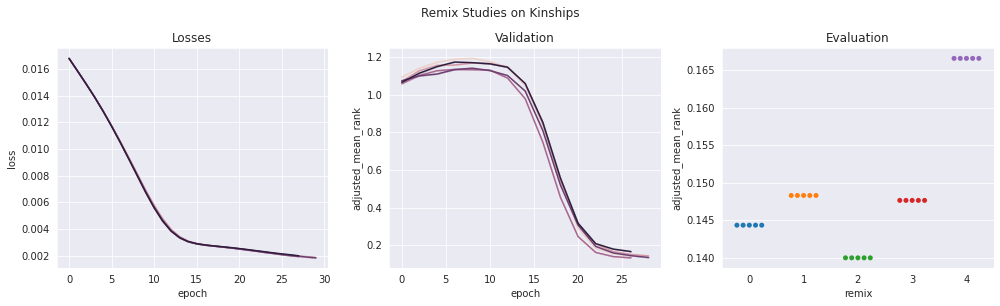

In [70]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(ncols=3, figsize=(14, 4))

sns.lineplot(data=loss_df, x='epoch', y='loss', hue='remix', legend=False, ax=axes[0])
axes[0].set_title('Losses')

sns.lineplot(data=val_df, x='epoch', y=metric, hue='remix', legend=False, ax=axes[1])
axes[1].set_title('Validation')

sns.swarmplot(data=res_df, x='remix', y=metric, ax=axes[2])
axes[2].set_title('Evaluation')

fig.subplots_adjust(top=0.8)
fig.suptitle('Remix Studies on Kinships', y=1.05)
fig.tight_layout()